In [1]:
import graphlab                            # see below for install instruction
import matplotlib.pyplot as plt          # plotting
import numpy as np                       # dense matrices
from scipy.sparse import csr_matrix      # sparse matrices

In [2]:
loans = graphlab.SFrame('lending-club-data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to oaabde01@louisville.edu and will expire on September 22, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\OMARAB~1\AppData\Local\Temp\graphlab_server_1477330305.log.0


In [4]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.remove_column('bad_loans')
target = 'safe_loans'
loans = loans[features + [target]]

In [11]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]
# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)
loans_data = risky_loans_raw.append(safe_loans)

In [12]:
#loans_data = risky_loans.append(safe_loans)

for feature in features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)

    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

loans_data.column_names()
#loans.column_names()

['safe_loans',
 'grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'emp_length.1 year',
 'emp_length.10+ years',
 'emp_length.2 years',
 'emp_length.3 years',
 'emp_length.4 years',
 'emp_length.5 years',
 'emp_length.6 years',
 'emp_length.7 years',
 'emp_length.8 years',
 'emp_length.9 years',
 'emp_length.< 1 year',
 'emp_length.n/a']

In [13]:
train_data, test_data = loans_data.random_split(.8, seed=1)

In [60]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    #data_weights = graphlab.SFrame([labels_in_node,data_weights])
    #data_weights.rename({'X1': 'labels_in_node', 'X2':'data_weights'})
    #positivenodes = data_weights[labels_in_node == +1]
    #total_weight_positive = sum(positivenodes['data_weights'])
    ##total_weight_positive = sum(data_weights[labels_in_node == +1])
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    #negativenodes=data_weights[labels_in_node == -1]
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    #total_weight_negative = sum(data_weights)
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_positive <= weighted_mistakes_all_negative:
        return (weighted_mistakes_all_positive,+1)
    else:
        return (weighted_mistakes_all_negative,-1)
        

In [62]:
# If the data is identical in each feature, this function should return None

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))
    data.remove_column('data_weights')
    data.add_column(data_weights, name='data_weights')
    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = left_split['data_weights'] 
        right_data_weights = right_split['data_weights']
        total_left_weights = sum(left_data_weights) 
        total_right_data_weights = sum(right_data_weights)
        total_weight = total_left_weights + total_right_data_weights
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        
        error = left_weighted_mistakes + right_weighted_mistakes / total_weight
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [17]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    # Store the predicted class (1 or -1) in leaf['prediction']
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class ## YOUR CODE HERE
    
    return leaf

In [18]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "Stopping condition 1 reached."                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print "Stopping condition 2 reached."                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print "Reached maximum depth. Stopping for now."
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print "Creating leaf node."
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "Creating leaf node."
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [19]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [20]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" % tree['prediction']
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print "Split on %s = %s" % (tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [21]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x))
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [58]:
target = 'safe_loans'
features = ['grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'emp_length.1 year',
 'emp_length.10+ years',
 'emp_length.2 years',
 'emp_length.3 years',
 'emp_length.4 years',
 'emp_length.5 years',
 'emp_length.6 years',
 'emp_length.7 years',
 'emp_length.8 years',
 'emp_length.9 years',
 'emp_length.< 1 year',
 'emp_length.n/a']

In [63]:
# Assign weights
example_data_weights = graphlab.SArray([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership.RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade.F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade.D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [88]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

In [89]:
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20_train3)

0.1

In [86]:
subset_20_train3 = train_data[:10]
subset_20_train4 = train_data[-10:]
subset_20_train3.append(subset_20_train4)

safe_loans,grade.A,grade.B,grade.C,grade.D,grade.E,grade.F,grade.G,term. 36 months,term. 60 months
-1,0,0,1,0,0,0,0,0,1
-1,0,0,0,0,0,1,0,0,1
-1,0,1,0,0,0,0,0,0,1
-1,0,0,1,0,0,0,0,1,0
-1,0,1,0,0,0,0,0,1,0
-1,0,1,0,0,0,0,0,1,0
-1,0,1,0,0,0,0,0,1,0
-1,0,0,1,0,0,0,0,1,0
-1,0,1,0,0,0,0,0,1,0
-1,0,0,1,0,0,0,0,1,0


In [84]:
train_data[:10]

safe_loans,grade.A,grade.B,grade.C,grade.D,grade.E,grade.F,grade.G,term. 36 months,term. 60 months
-1,0,0,1,0,0,0,0,0,1
-1,0,0,0,0,0,1,0,0,1
-1,0,1,0,0,0,0,0,0,1
-1,0,0,1,0,0,0,0,1,0
-1,0,1,0,0,0,0,0,1,0
-1,0,1,0,0,0,0,0,1,0
-1,0,1,0,0,0,0,0,1,0
-1,0,0,1,0,0,0,0,1,0
-1,0,1,0,0,0,0,0,1,0
-1,0,0,1,0,0,0,0,1,0


In [85]:
train_data[-10:]

safe_loans,grade.A,grade.B,grade.C,grade.D,grade.E,grade.F,grade.G,term. 36 months,term. 60 months
1,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,1
1,0,0,0,1,0,0,0,1,0


In [91]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = graphlab.SArray([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print '====================================================='
        print 'Adaboost Iteration %d' % t
        print '====================================================='        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        ##alp = numpy.array(alpha)
        ##is_wr = numpy.array(is_wrong)
        ##upper_weight_error = sum(alp * is_wr)
        ##alpha_summation = sum(alp)
        upper_weight_error = sum(alpha * is_wrong)
        alpha_summation = sum(alpha)
        weighted_error = upper_weight_error / alpha_summation
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        upper_weight = 1 - weighted_error
        lower_weight = weighted_error
        logvar = upper_weight / lower_weight
        weight = 0.5 * numpy.log(logvar)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha = alpha * adjustment
        alpha = alpha / alpha_summation
    
    return weights, tree_stumps

In [94]:
#import numpy
num_tree_stumps = 30

In [105]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = graphlab.SArray([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Accumulate predictions on scaores array
        # YOUR CODE HERE
        scores = stump_weights[i] * predictions + scores
    scores = numpy.sign(scores)
    scores = graphlab.SArray(data=scores, dtype=int)
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [96]:
stump_weights,tree_stumps = adaboost_with_tree_stumps(train_data, features, target, 10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

In [106]:
error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - graphlab.evaluation.accuracy(train_data[target], predictions)
    error_all.append(error)
    print "Iteration %s, training error = %s" % (n, error_all[n-1])

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.433430045132
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.400037610144
Iteration 5, training error = 0.384724908661
Iteration 6, training error = 0.384617451107
Iteration 7, training error = 0.382763808296
Iteration 8, training error = 0.384617451107
Iteration 9, training error = 0.382763808296
Iteration 10, training error = 0.384483129164
Iteration 11, training error = 0.384483129164
Iteration 12, training error = 0.384483129164
Iteration 13, training error = 0.384483129164
Iteration 14, training error = 0.384483129164
Iteration 15, training error = 0.384483129164
Iteration 16, training error = 0.384483129164
Iteration 17, training error = 0.384483129164
Iteration 18, training error = 0.384483129164
Iteration 19, training error = 0.384483129164
Iteration 20, training error = 0.384483129164
Iteration 21, training error = 0.384483129164
Iteration 22, training error = 0.3844831291

In [107]:
import matplotlib

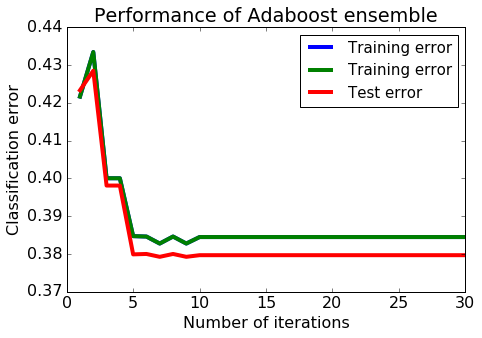

In [118]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})


plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

make_figure(dim=(10,5), title='Performance of Adaboost ensemble',
            xlabel='Number of iterations',
            ylabel='Classification error',
            legend='best')

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [117]:
test_error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - graphlab.evaluation.accuracy(test_data[target], predictions)
    test_error_all.append(error)
    print "Iteration %s, training error = %s" % (n, test_error_all[n-1])

Iteration 1, training error = 0.42330891857
Iteration 2, training error = 0.428479103835
Iteration 3, training error = 0.398104265403
Iteration 4, training error = 0.398104265403
Iteration 5, training error = 0.379900904782
Iteration 6, training error = 0.380008616975
Iteration 7, training error = 0.379254631624
Iteration 8, training error = 0.380008616975
Iteration 9, training error = 0.379254631624
Iteration 10, training error = 0.379685480396
Iteration 11, training error = 0.379685480396
Iteration 12, training error = 0.379685480396
Iteration 13, training error = 0.379685480396
Iteration 14, training error = 0.379685480396
Iteration 15, training error = 0.379685480396
Iteration 16, training error = 0.379685480396
Iteration 17, training error = 0.379685480396
Iteration 18, training error = 0.379685480396
Iteration 19, training error = 0.379685480396
Iteration 20, training error = 0.379685480396
Iteration 21, training error = 0.379685480396
Iteration 22, training error = 0.37968548039